# Numeričko rješavanje sustava linearnih jednadžbi i inicijalnog problema za ODJ

## Sadržaj
1. Numeričko rješavanje sustava linearnih jednadžbi

    1.1. Uvod i motivacija
    
    1.2. Pozadina metodâ
    
    1.3. Metode
            
        1.3.1. Jacobijeva metoda
        
        1.3.2. Gauss–Seidelova metoda
        
        1.3.1. SOR metoda
    
    1.4. Testiranje i usporedba metoda na primjerima

    1.5. Zaključak (?)
    

2. Numeričko rješavanje inicijalnog problema za ODJ
    
    2.1. Uvod
    
    2.2. Jednokoračne metode
        
        2.2.1. Eulerova metoda
        
        2.2.2. Trapezna metoda
        
    2.3. Višekoračne metode
        
        2.3.1. Adams–Bashforthova metoda
    
    2.4. Testiranje i usporedba na primjerima
    
    2.5. Zaključak (?)
    

3. Literatura

In [3]:
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
from PIL import Image

## 1. Numeričko rješavanje sustava linearnih jednadžbi

### 1.1. Uvod i motivacija

Jedan od osnovnih problema numeričke matematike je rješavanje linearnih sustava jednadžbi. U ovom eseju istraživat ćemo metode za rješavanje kvadratnih $n\times n$ sustava, odnosno sustava od $n$ jednadžbi s $n$ nepoznanica,

$$
\begin{equation}
a_{11}x_{1} + a_{12}x_{2} + ... + a_{1j}x_{j} + ... + a_{1n}x_{n} = b_{1}\\
a_{21}x_{1} + a_{22}x_{2} + ... + a_{2j}x_{j} + ... + a_{2n}x_{n} = b_{2}\\
\vdots\\
a_{i1}x_{1} + a_{i2}x_{2} + ... + a_{ij}x_{j} + ... + a_{in}x_{n} = b_{i}\\
\vdots\\
a_{n1}x_{1} + a_{n2}x_{2} + ... + a_{nj}x_{j} + ... + a_{nn}x_{n} = b_{n}\\
\end{equation}
$$

Matricu $A=(a_{ij})_{i,j=1}^{n}$ nazivamo <b>matrica sustava</b>, a njeni elementi su <b>koeficijenti sustava</b>. Vektor $b=(b_{i})_{i=1}^{n}$ naziva se <b>vektor desne strane</b>. Trebamom odrediti <b>vektor nepoznanica</b> $x$, $x=(x_{i})_{i=1}^{n}$ tako da vrijedi $Ax=b$.

Iz linearne algebre znamo da je rješavanje sustava $Ax=b$ za teorijsku matematiku gotovo trivijalan problem, posebno u slučaju kada je matrica sustava kvadratna i regularna. Rješenje $x$ dano je formulom $x=A^{-1}b$, gdje je $A^{-1}$ inverzna matrica od $A$ ($AA^{-1}=A^{-1}A=I$). Pri tome postoje eksplicitne formule i za elemente matrice $A^{-1}$ i za samo rješenje $x$. Osim toga, Gaussova metoda eliminacija dolazi do rješenja $x$ u $O(n^{3})$ elementarnih operacija (gdje su elementarne operacije: zbrajanje, oduzimanje, množenje i dijeljenje).

Dakle, znamo da rješenje $x=A^{-1}b$ postoji, jedinstveno je i postoji jednostavan algoritam koji to rješenje eksplicitno računa koristeći konačno mnogo jednostavnih aritmetičkih operacija.
Na žalost, konačna aritmetika računala niti te jednostavne operacije ne može izvršavati egzaktno pa Gaussovim eliminacijama (koje su jednostavno konačan niz formula koje vode rješenju) rješenje linearnog sustava $Ax=b$ općenito ne možemo izračunati apsolutno točno.

Iz tog razloga, uvodimo iterativne metode. Iterativne metode ne daju egzaktno rješenje, nego aproksimaciju tog rješenja. Pokazat će se da pomoću iterativnih metoda ne znamo egzaktno rješenje, ali znamo koliko smo "blizu" egzaktnom rješenju.

Metode koje ćemo navesti i objasniti su Jacobijeva, Gauss–Seidelova i SOR (successive over-relaxation) metoda.

### 1.2. Pozadina metodâ

Pretpostavimo da rješavamo sustav $Ax=b$ za koji vrijedi $\det A\neq0$. Budući da umjesto egzaktnog rješenja $x$, moramo koristiti neku aproksimaciju $\tilde{x}$, moramo imati način procjene kvalitete aproksimacije. Jedan način je izračunati normu $\delta x$, gdje je $\delta x = \tilde{x} - x$, no budući da je $x$ nepoznanica, to nije moguće. Drugi način je da izračunamo rezidual

$$ r = b - A\tilde{x} \label{eq:1}\tag{1} $$

Reći ćemo da je $\tilde{x}$ dobra aproksimacija od $x$ ako je, u nekoj normi $\|\cdot\|$, vrijednost $\epsilon:=\frac{||r||}{||b||}$ dovoljno mala.

Takav kriterij možemo opravdati činjenicom da je iz $\eqref{eq:1}$
$$ A\tilde{x} = \tilde{b}\equiv b-r, \frac{||\tilde{b}-b||}{||b||}=\frac{||r||}{||b||}=\epsilon.$$

Kažemo da $\tilde{x}$ egzaktno rješava sustav koji je blizak zadanom, s kontroliranom razlikom u desnoj strani sustava, vektoru $b$.

Prethodna diskusija motivira nas da potražimo i drugačije pristupe za rješavanje linearnog sustava $Ax=b$. Primijetimo da ne moramo nužno težiti pronalaženju egzaktnog rješenja. Dakle, želimo <i>dovoljno dobru</i> aproksimaciju $\tilde{x}\approx A^{-1}b$. Zbog toga ima smisla pokušati konstruirati niz $x^{(0)},x^{(1)},x^{(2)},...,x^{(k)},...$ vektora sa sljedećim svojstvima:
- Za svaki $k\in\mathbb{N}$ formula za računanje $x^{(k)}$ je jednostavna i matrica $A$ se koristi samo kao funkcijski potprogram koji računa $v\mapsto f(A)v$, gdje je $v$ vektor, a $f(A)$ označava $A,A^{*},A^{T}$ ili neki dio od $A$ (npr. $diag(A)$, gornji ili donji trokut od $A$ i sl.)
- $x^{(k)}$ teži prema $x=A^{-1}b$ i za neki $k$ (obično $k\ll n$), $x^{(k)}$ je prihvatljiva aproksimacija za $x$.

Ova svojstva su namjerno dana u nepreciznom obliku. Detalji koji ovise o konkretnom problemu i ko konkretnom načinu konstrukcije niza $(x^{(k)}$  bit će dani kada budemo opisivali metodu (metode).

Napišimo matricu $A$ kao $A=M-N$, gdje je $M$ regularna matrica i $M^{-1}A\approx I$. Imamo:

$$Mx=Nx+b,\;\text{ or }\; x=M^{-1}Nx+M^{-1}b \label{eq:2}\tag{2}$$

Označimo $F:=M^{-1}N$ i $c:=M^{-1}b$. To je problem fiksne točke $x=Fx+c$, sa $F=M^{-1}N=M^{-1}(M-A)=I-M^{-1}A$ pa je prirodno pokušati jednostavne iteracije:

$$ x^{(k+1)}=Fx^{(k)}+c. \label{eq:3}\tag{3} $$

Ubacivanjem $F=I-M^{-1}A$ i $c=M^{-1}b$ vidimo da se iteracije iz $\eqref{eq:3}$ mogu zapisati i kao

$$ x^{(k+1)}=x^{(k)}+M^{-1}r_{k},\;\text{gdje je}\;\; r_{k}=Ax^{(k)} \label{eq:4}\tag{4}$$

Intuitivno, ako smo $M$ odabrali tako da znamo koristiti $M^{-1}$ i tako da je $M^{-1}\approx A^{-1}$, onda je 

$$ x^{(k+1)}=x^{(k)} + M^{-1}r_{k}\approx x^{(k)} + A^{-1}r_{k}= x^{(k)} + x - x^{(k)}=x.$$

Kažemo da je $M$ prekondicioner za $A$ u smislu da $M^{-1}$ aproksimira $A^{-1}$. Ako imamo dobar izbor matrice $M$, onda polazni sustav $Ax=b$ možemo zamijeniti ekvivalentnim $(M^{-1}A)x=M^{-1}b$ čija matrica koeficijenata $M^{-1}A$ ima bolja svojstva od $A$.

Najveći dio problema je u tome kako odabrati rastav matrice $A$ kao $A=M-N$ koji će za neke klase problema osigurati konvergenciju. Za Jacobijevu, Gauss–Seidelovu i SOR metodu ti su rastavi izvedeni iz sljedeće reprezentacije matrice $A$:

$$ A = D(I-L-U) \label{eq:5}\tag{5}$$

$D=diag(A)$, $L$ je strogo donje trokutasta, a $U$ je strogo gornje trokutasta. Također, koristit ćemo i sljedeći rastav:
$$ A = D - \hat{L} - \hat{U},\; \hat{L}=DL,\; \hat{U}=DU$$

### 1.3. Metode

####  1.3.1. Jacobijeva metoda

Jacobijeva metoda definirana je za matricu $A\in\mathbb{M}_{n}$ za koju je $a_{ii}\neq0, \forall i=1,...,n$. Za matricu $M$ ćemo uzeti dijagonalu od $A$, $M=\diag{A}$, pa je $N$ izvandijagonalni dio od $-A$. Matricu $F=D^{-1}(D-A)$ označimo sa $J$, gdje je u terminima $\eqref{eq:5}$:

$$ J=L+U \label{eq:6}\tag{6}$$



Jacobijeve iteracije $x^{(k+1)}=Jx^{(k)}+D^{-1}b$ po elementima glase:

$$ x_i^{(k+1)}=\frac{1}{a_{ii}}(b_{i}-\sum_{j=1\\j\neq i}^{n}a_{ij}x_{j}^{(k)})\label{eq:7}\tag{7}$$

Jacobi algoritam:

In [19]:
A = np.ones((3,3))
#B = np.diag(np.diag(A))
#C = np.linalg.inv(B)
#print(B)
#print(C)
d = np.array([1,1,1])
#print(np.dot(A,d))
#e = np.array([[4,5,6],[7,8,9],[10,11,12]])
#g = np.append(d, e).reshape(4,3)
#print(g)
g = d
g = g + d
print(g)
print(np.dot(A,d))

[2 2 2]
[3. 3. 3.]


In [26]:
A = np.ones((3,3))
B = np.diag(np.diag(A))
x = np.ones(3)
print(A,B,x,sep='\n')


[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[1. 1. 1.]


In [20]:
5%100

5

In [7]:
print(len(g))
g = g.reshape(4,3)
print(g)

4
[[ 1  1  1]
 [ 4  5  6]
 [ 7  8  9]
 [10 11 12]]


In [67]:
def jacobi(x, A, b, tolerance):
    # initial guess x to the solution, diagonally dominant matrix A,
    # right-hand side vector b, convergence criterion tolerance
    
    # A je kvadratna pa nije vazno uzimamo li broj redaka ili stupaca
    n = len(A)
    
    # dekompozicija matrice A -> M = (diag(A))^{-1}
    M = np.diag(np.diag(A))
    inverseM = np.linalg.inv(M)
    # J = M^{-1}(M-A)
    A = M - A
    matrix = inverseM @ A
    vector = inverseM @ b
    
    # vektor reziduala svake iteracije
    residual = np.array([np.linalg.norm(b - A*x)])
    
    # matrica koja u retku i ima aproksimaciju dobivenu u i-toj iteraciji 
    approximations = np.array(x)
    k = 0
    
    while residual[k] >= tolerance:
        k = k + 1
        residual = np.append(residual, np.linalg.norm(b - A@x))
        x = matrix@x + vector
        approximations = np.append(approximations, x).reshape(len(approximations)%n, n)
    return x, residual, approximations

#### 1.3.2. Gauss–Seidel metoda

Gledajući formulu $\eqref{eq:7}$ Jacobijeve metode, možemo primijetiti da su u trenutku računanja $x_{i}^{(k+1)}$, vrijednosti $x_{1}^{(k+1)},...,x_{i-1}^{(k+1)}$ već poznate. Budući da očekujemo da naše iteracije konvergiraju, razumno je očekivati da su $x_{1}^{(k+1)},...,x_{i-1}^{(k+1)}$ bolje vrijednosti od $x_{1}^{(k)},...,x_{i-1}^{(k)}$. Iz tog razloga uvodimo sljedeću formulu za računanje $x^{(k+1)}$:

$$ x_i^{(k+1)}=\frac{1}{a_{ii}}(b_{i}-\sum_{j=1}^{i-1}a_{ij}x_{j}^{(k+1)}-\sum_{j=i+1}^{n}a_{ij}x_{j}^{(k)}),\; i=1,...,n\label{eq:8}\tag{8}$$

U terminima $\eqref{eq:5}$, metoda glasi:

$$ x^{(k+1)}=Gx^{(k)}+(I-L)^{-1}D^{-1}b,\; G = (I-L)^{-1}U\label{eq:9}\tag{9}$$

Gauss–Seidel algoritam:

In [68]:
def gaussSeidel(x, A, b, tolerance):
    # initial guess x to the solution, diagonally dominant matrix A,
    # right-hand side vector b, convergence criterion tolerance
    
    # A je kvadratna pa nije vazno uzimamo li broj redaka ili stupaca
    n = len(A)
    
    # dekompozicija matrice A
    D = np.linalg.inv(np.diag(np.diag(A)))
    U = D @ np.triu(A)
    L = D @ np.tril(A)
    IL = np.linalg.inv(np.eye(n) - L)
    matrix = IL @ U
    vector = IL @ (D@b)
    
    # vektor reziduala svake iteracije
    residual = np.array([np.linalg.norm(b - A*x)])
    
    # matrica koja u retku i ima aproksimaciju dobivenu u i-toj iteraciji 
    approximations = np.array(x)
    k = 0
    
    while residual[k] >= tolerance:
        k = k + 1
        residual = np.append(residual, np.linalg.norm(b - A@x))
        x = matrix@x + vector
        approximations = np.append(approximations, x).reshape(len(approximations)%n, n)
    return x, residual, approximations

#### 1.3.3. SOR metoda

SOR metoda je varijacija na Gauss–Seidelovu metodu, koja u konačnici dovodi do brže konvergencije. Analognim zaključivanjem za bilo koju sporo konvergirajuću metodu možemo kreirati bržu metodu. Ideja SOR metode je jednostavna: u Gauss–Seidelovu metodu ubacimo jedan slobodan parametar $\omega\in\mathbb{R}$ te pokušamo namjestiti $\omega$  kako bismo dobili bržu konvergenciju. Pri tome zadržavamo osnovnu ideju Gauss–Seidelove metode – koristimo najsvježije podatke:

$$ x_i^{(k+1)}=(1-\omega)x_{i}^{(k)} + \frac{\omega}{a_{ii}}(b_{i}-\sum_{j=1}^{i-1}a_{ij}x_{j}^{(k+1)}-\sum_{j=i+1}^{n}a_{ij}x_{j}^{(k)}),\; i=1,...,n\label{eq:10}\tag{10}$$

U terminima $\eqref{eq:5}$, metoda glasi:

$$ x^{(k+1)}=Sx^{(k)}+\omega(I-\omega L)^{-1}D^{-1}b,\; S = (I-\omega L)^{-1}((1-\omega)I+\omega U)\label{eq:11}\tag{11}$$

In [31]:
def sor(x, A, b, omega, tolerance):
    # initial guess x to the solution, diagonally dominant matrix A,
    # right-hand side vector b, convergence criterion tolerance
    
    # A je kvadratna pa nije vazno uzimamo li broj redaka ili stupaca
    n = len(A)
    
    # dekompozicija matrice A
    D = np.linalg.inv(np.diag(np.diag(A)))
    U = (1-omega)*np.eye(n) + omega * (D@np.triu(A))
    L = omega * (D@np.tril(A))
    IL = np.linalg.inv(np.eye(n) - L)
    
    matrix = IL @ U
    vector = omega * (IL @ (D@b))
    
    # vektor reziduala svake iteracije
    residual = np.array([np.linalg.norm(b - A*x)])
    
    # matrica koja u retku i ima aproksimaciju dobivenu u i-toj iteraciji 
    approximations = np.array(x)
    approximations.shape
    k = 0
    
    while residual[k] >= tolerance:
        k = k + 1
        residual = np.append(residual, np.linalg.norm(b - A@x))
        x = matrix@x + vector
        approximations = np.append(approximations, x).reshape(k+1, n)
    return x, residual, approximations

Za odabir optimalnog omege, prije testiranja ispitat ćemo moguće kandidate i izabrati optimalnu vrijednost. Sad se možemo pitati: zar ćemo testirati za sve realne brojeve? No, odabir će nam olakšati Kahanov teorem:

$\text{Neka je S matrica SOR metode s parametrom }\omega. \text{ Tada je spr(S) }\geq|\omega-1|.\text{ Dakle, za konvergenciju SOR metode nužno je da je } \omega\in(0,2)$.

### 1.4. Testiranje i usporedba metoda na primjerima

Testiranje Jacobijeve, Gauss–Seidelove i SOR metode provest ćemo na nekoliko različitih matrica. Jedna od njih je jedan primjer Stieltjesove matrice. Stieltjesova matrica je realna simetrična pozitivno definitna matrica kojoj su elementi izvan dijagonale nepozitivni ($\leq 0$). Testiranje ćemo provesti s vektorom desne strane takvim da je egzaktno rješenje vektor jedinica. Također, postavimo toleranciju na $1\text{e-8}$. Početna aproksimacija neka bude nulvektor.

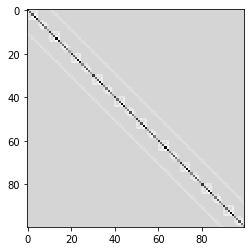

In [22]:
tolerance = 1e-8
stieltjes = np.genfromtxt('stieltjes.txt').reshape(100,100)
one = np.ones(len(stieltjes))
rhs = stieltjes @ one
x = np.zeros(len(stieltjes))
plt.imshow(stieltjes, interpolation='nearest',cmap='gray_r')
#find more acceptable colormap
plt.show()

Najprije pronađimo optimalan $\omega\in(0,2)$ za SOR metodu. Za naše potrebe, neka je $\omega$ neki realan broj s najviše dvije decimale.

In [32]:
omegas = np.linspace(0.01,1.99,199)
stepNumber = np.zeros(len(omegas))
ones = np.ones(len(stieltjes))
rhs = stieltjes @ ones
for i in range(len(omegas)):
    x, residual, approximation = sor(ones, stieltjes, rhs, omegas[i], tolerance)
    stepNumber[i] = len(residual)
fig1, ax1 = plt.subplots()
ax1.plot(omegas, stepNumber, label='Broj iteracija',color='red')

LinAlgError: Singular matrix

In [73]:
xJacobi, resJacobi, approxJacobi = jacobi(x, A, b, tolerance)
gaussSeidel(x, A, b, tolerance)
sor(x, A, b, omega, tolerance)

# 2. Numeričko rješavanje

## 3. References

Iterative method: https://en.wikipedia.org/wiki/Iterative_method

Jacobi method: https://en.wikipedia.org/wiki/Jacobi_method

Gauss$-$Seidel method: https://en.wikipedia.org/wiki/Gauss%E2%80%93Seidel_method

SOR method: https://en.wikipedia.org/wiki/Successive_over-relaxation

Stieltjes matrix: https://en.wikipedia.org/wiki/Stieltjes_matrix

Osnovni elementi koje morate imati (bez kojih se zadaća ne smatra predanom, i nemate uvjet za prolaz) su barem 5 od sljedećih 6:

- barem 3 funkcije ili klase koje ste sami napisali
- barem 99 linija koda (ne računaju se prazne linije, linije koje sadrže isključivo komentare, te duplicirane linije s trivijalnim izmjenama)
- barem 5 slika (grafova ili drugačijih vizualizacija) kreiranih u bilježnici (ubacivanje gotovih slika/videa je dopušteno, ali se ne računa za ovaj kriterij)
- barem 3 objekta, metode ili funkcije iz paketa Numpy, Scipy, Pandas ili Matplotlib, koje su obrađene na "predavanjima", i barem 3 koje nisu
- barem 3 objekta, metode ili funkcije iz nekog Anacondinog paketa koji nije obrađen na "predavanjima" (ne mora biti dio standardne instalacije, ali u tom slučaju napišite koje ste dodatne pakete koristili i kako se instaliraju)
- barem 3 objekta, metode ili funkcije iz standardne Pythonove biblioteke koje nisu obrađene na predavanjima